# KAIM Week 11 Challenges

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

warnings.filterwarnings('ignore')


## Load Data

In [2]:
# Define the assets and date range for data extraction
assets = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

# Download data from YFinance
data = yf.download(assets, start=start_date, end=end_date)

# Data structure adjustment: select Adjusted Close prices only
data = data['Adj Close']
data.columns = ['TSLA', 'BND', 'SPY']
data.reset_index(inplace=True)

# Display the first few rows to check the data format
data.head()

[*********************100%***********************]  3 of 3 completed


,Date,TSLA,BND,SPY
0,2015-01-02 00:00:00+00:00,63.358734,173.173782,14.620667
1,2015-01-05 00:00:00+00:00,63.542770,170.046280,14.006000
2,2015-01-06 00:00:00+00:00,63.726692,168.444641,14.085333
3,2015-01-07 00:00:00+00:00,63.765060,170.543671,14.063333
4,2015-01-08 00:00:00+00:00,63.665386,173.569992,14.041333


## Data Cleaning and Understanding

In [3]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

data.head()


,Date,TSLA,BND,SPY
0,2015-01-02 00:00:00+00:00,63.358734,173.173782,14.620667
1,2015-01-05 00:00:00+00:00,63.542770,170.046280,14.006000
2,2015-01-06 00:00:00+00:00,63.726692,168.444641,14.085333
3,2015-01-07 00:00:00+00:00,63.765060,170.543671,14.063333
4,2015-01-08 00:00:00+00:00,63.665386,173.569992,14.041333


In [4]:
# Check basic statistics
data.describe()

# Check data types and missing values
print(data.info())
print("Missing Values:\n", data.isnull().sum())

# Handle missing values: fill forward or interpolate
data.fillna(method='ffill', inplace=True)
data.interpolate(method='linear', inplace=True)

# Confirm missing values are handled
print("Missing Values after Handling:\n", data.isnull().sum())

# Normalize the data for consistency
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['TSLA', 'BND', 'SPY']] = scaler.fit_transform(data[['TSLA', 'BND', 'SPY']])

# Check the normalized data
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474 entries, 0 to 2473
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    2474 non-null   datetime64[ns, UTC]
 1   TSLA    2474 non-null   float64            
 2   BND     2474 non-null   float64            
 3   SPY     2474 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 77.4 KB
None
Missing Values:
 Date    0
TSLA    0
BND     0
SPY     0
dtype: int64
Missing Values after Handling:
 Date    0
TSLA    0
BND     0
SPY     0
dtype: int64


,TSLA,BND,SPY
count,2474.000000,2474.000000,2474.000000
mean,0.433860,0.357918,0.254403
std,0.284705,0.260381,0.275032
min,0.000000,0.000000,0.000000
25%,0.214059,0.134563,0.018702
50%,0.363974,0.277310,0.038625
75%,0.650347,0.573347,0.517710
max,1.000000,1.000000,1.000000


## Exploratory Data Analysis (EDA)

### Closing Prices Over Time

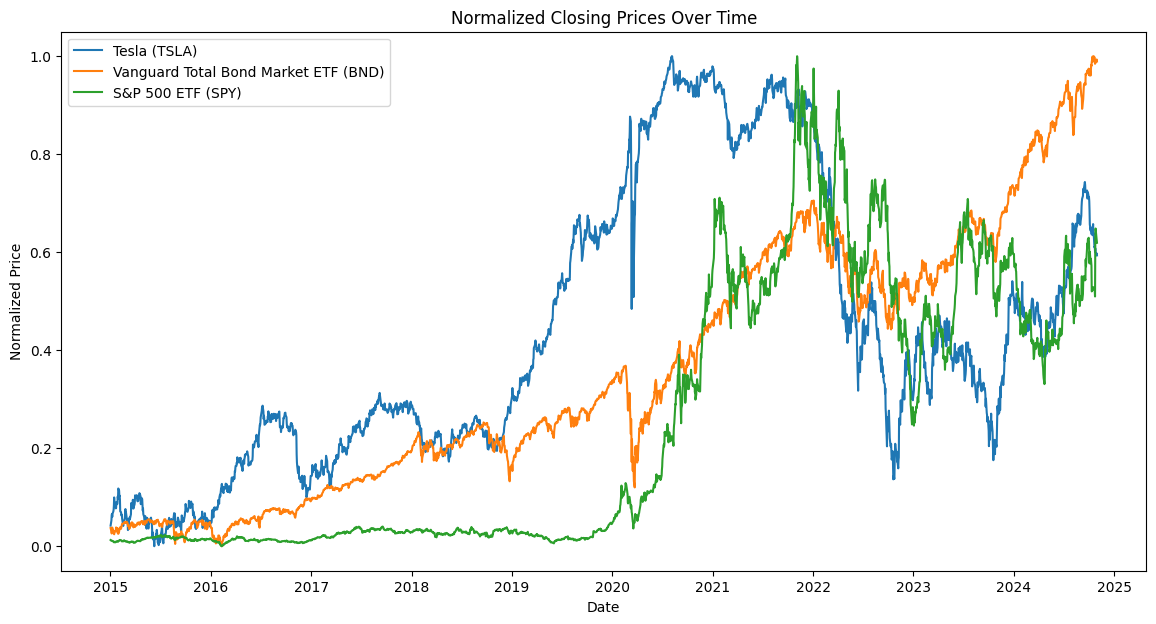

In [7]:
# Plot closing prices for each asset
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['TSLA'], label='Tesla (TSLA)')
plt.plot(data['Date'], data['BND'], label='Vanguard Total Bond Market ETF (BND)')
plt.plot(data['Date'], data['SPY'], label='S&P 500 ETF (SPY)')
plt.title('Normalized Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


### Daily Percentage Change in Asset Prices

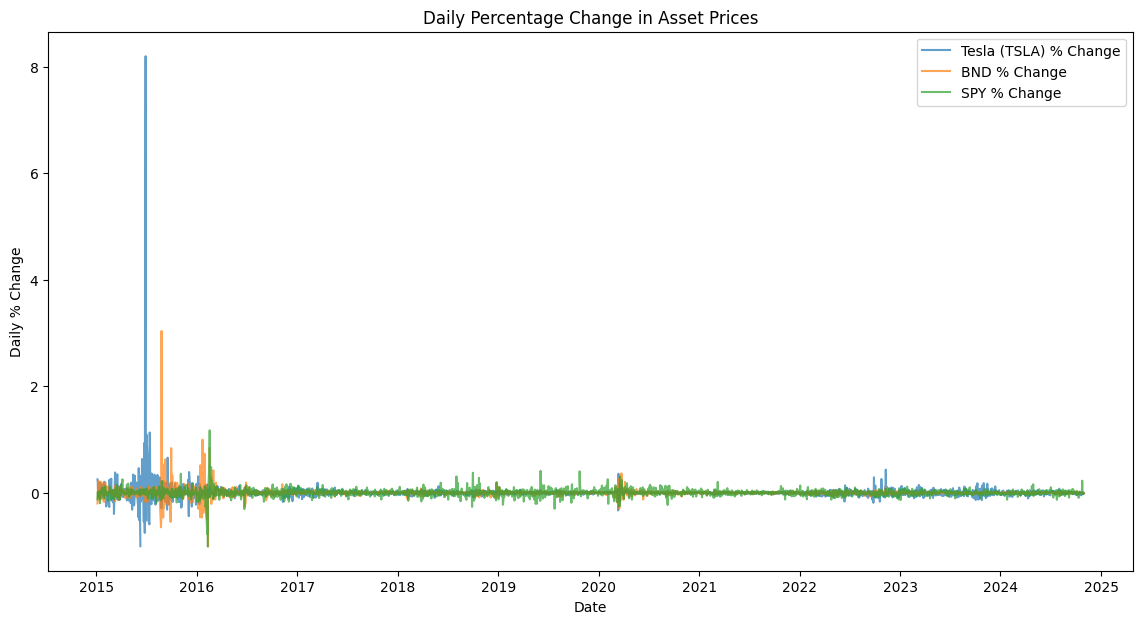

In [8]:
# Calculate daily percentage change
data[['TSLA_pct_change', 'BND_pct_change', 'SPY_pct_change']] = data[['TSLA', 'BND', 'SPY']].pct_change()

# Plot daily percentage change for each asset
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['TSLA_pct_change'], label='Tesla (TSLA) % Change', alpha=0.7)
plt.plot(data['Date'], data['BND_pct_change'], label='BND % Change', alpha=0.7)
plt.plot(data['Date'], data['SPY_pct_change'], label='SPY % Change', alpha=0.7)
plt.title('Daily Percentage Change in Asset Prices')
plt.xlabel('Date')
plt.ylabel('Daily % Change')
plt.legend()
plt.show()


### Rolling Mean and Standard Deviation for Tesla (TSLA)

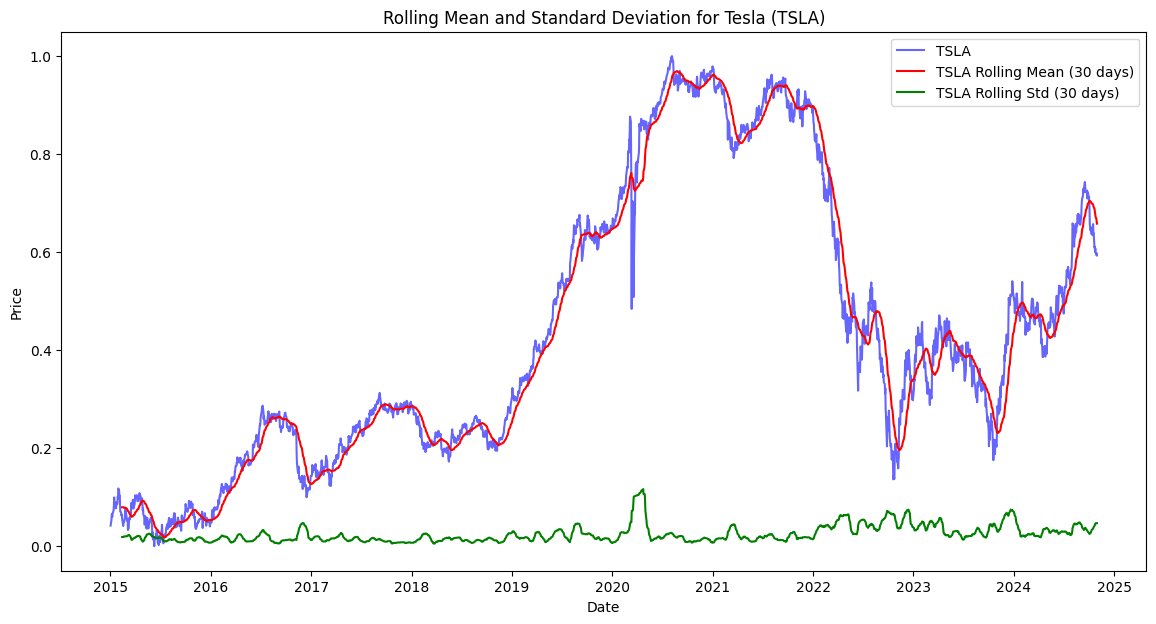

In [9]:
# Calculate rolling mean and standard deviation (30-day window)
data['TSLA_rolling_mean'] = data['TSLA'].rolling(window=30).mean()
data['TSLA_rolling_std'] = data['TSLA'].rolling(window=30).std()

# Plot rolling statistics for Tesla stock price
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['TSLA'], label='TSLA', color='blue', alpha=0.6)
plt.plot(data['Date'], data['TSLA_rolling_mean'], label='TSLA Rolling Mean (30 days)', color='red')
plt.plot(data['Date'], data['TSLA_rolling_std'], label='TSLA Rolling Std (30 days)', color='green')
plt.title('Rolling Mean and Standard Deviation for Tesla (TSLA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### Outlier Detection

c:\Users\hp\KAIM\KAIM-W11\.week11\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


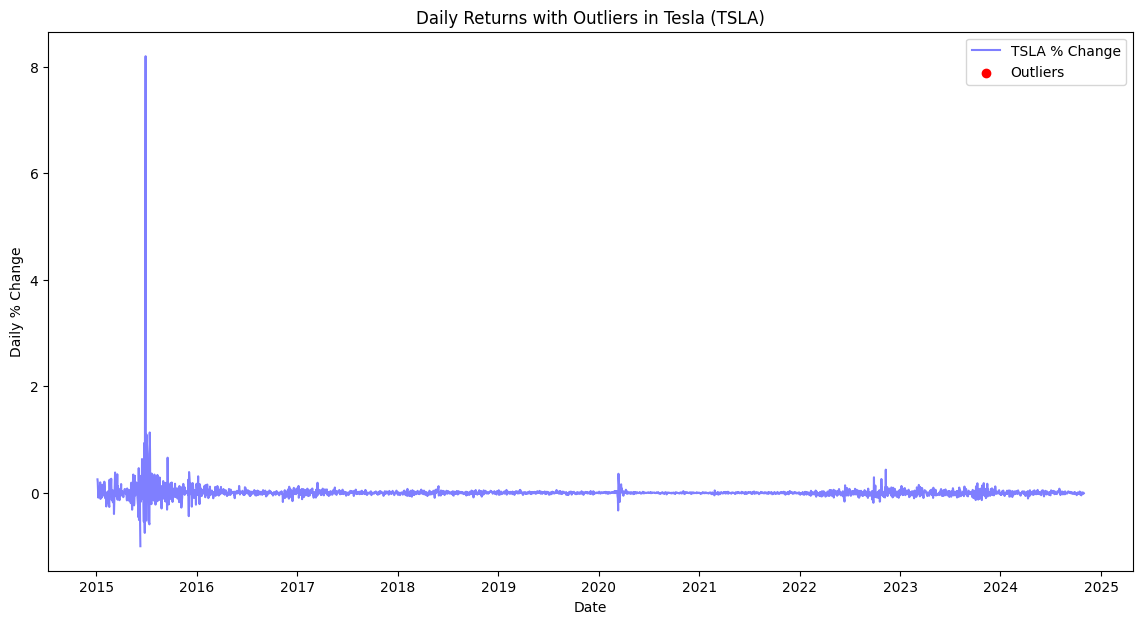

,Date,TSLA,TSLA_pct_change


In [10]:
# Identify outliers using daily percentage change with Z-score
data['TSLA_pct_change_zscore'] = (data['TSLA_pct_change'] - data['TSLA_pct_change'].mean()) / data['TSLA_pct_change'].std()

# Define outlier threshold
outlier_threshold = 3

# Filter data for outliers in Tesla stock
outliers = data[np.abs(data['TSLA_pct_change_zscore']) > outlier_threshold]

# Plot daily returns with outliers highlighted
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['TSLA_pct_change'], label='TSLA % Change', color='blue', alpha=0.5)
plt.scatter(outliers['Date'], outliers['TSLA_pct_change'], color='red', label='Outliers', marker='o')
plt.title('Daily Returns with Outliers in Tesla (TSLA)')
plt.xlabel('Date')
plt.ylabel('Daily % Change')
plt.legend()
plt.show()

# Display the outliers
outliers[['Date', 'TSLA', 'TSLA_pct_change']]


### Seasonality and Trend Analysis

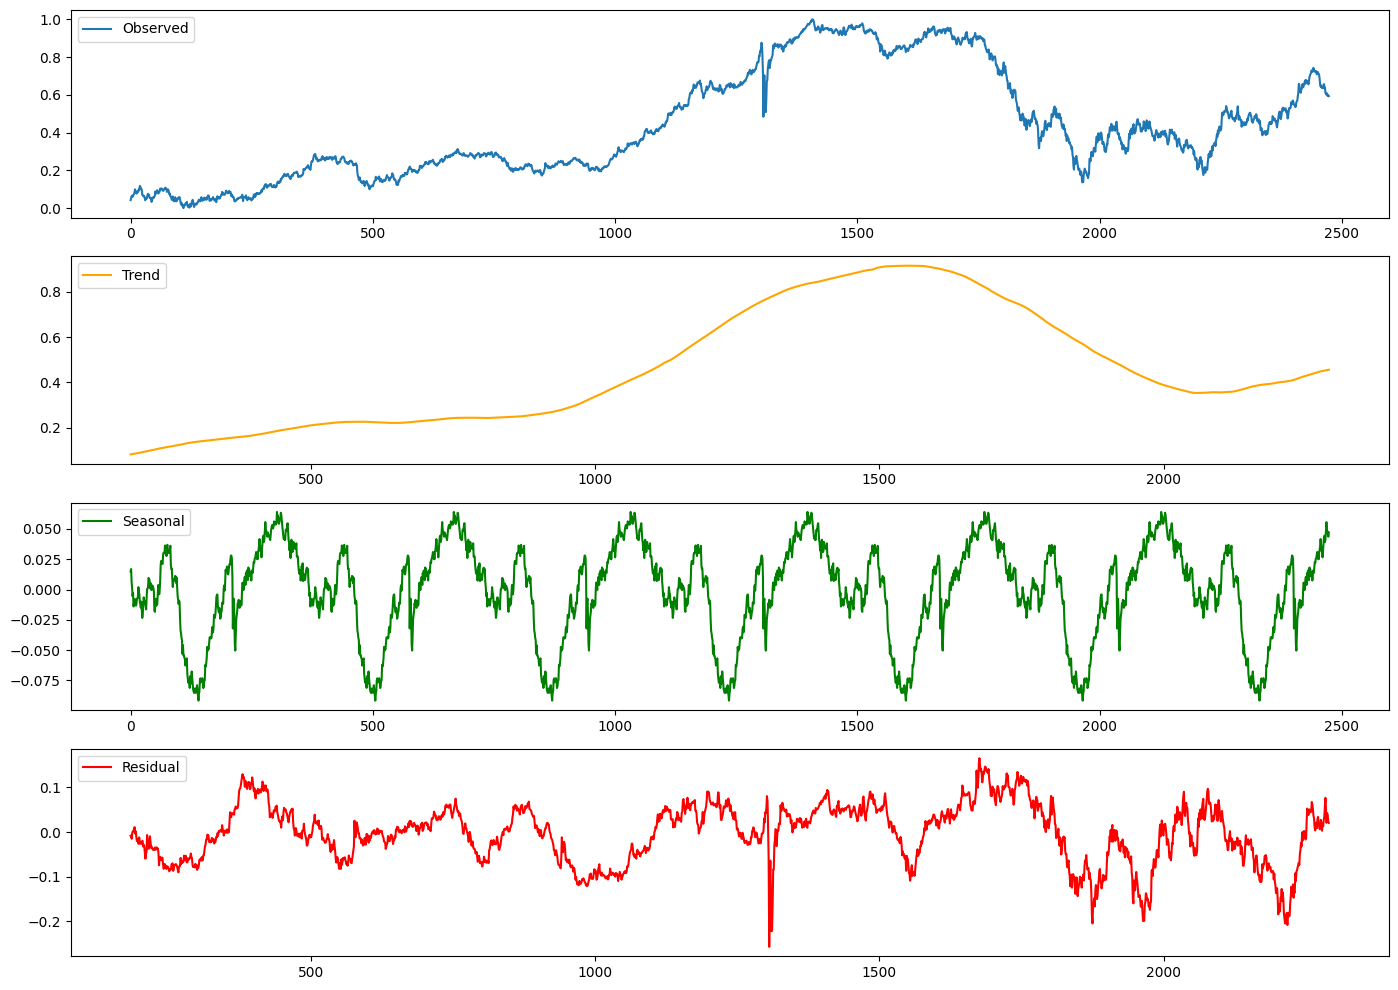

In [11]:
# Decompose the Tesla time series (additive model)
tsla_decomposed = seasonal_decompose(data['TSLA'].dropna(), model='additive', period=365)

# Plot decomposition results
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(tsla_decomposed.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(tsla_decomposed.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(tsla_decomposed.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(tsla_decomposed.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Volatility and Risk Metrics

In [12]:
# Value at Risk (VaR) at 95% confidence level for Tesla daily returns
confidence_level = 0.05
VaR_95 = np.percentile(data['TSLA_pct_change'].dropna(), confidence_level * 100)
print(f"Value at Risk (VaR) at 95% confidence level: {VaR_95:.4f}")

# Sharpe Ratio calculation (assuming a risk-free rate of 0 for simplicity)
risk_free_rate = 0
mean_return = data['TSLA_pct_change'].mean()
std_return = data['TSLA_pct_change'].std()
sharpe_ratio = (mean_return - risk_free_rate) / std_return
print(f"Sharpe Ratio for Tesla: {sharpe_ratio:.2f}")


Value at Risk (VaR) at 95% confidence level: -0.0795
Sharpe Ratio for Tesla: nan


c:\Users\hp\KAIM\KAIM-W11\.week11\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Correlation Matrix:
           TSLA       BND       SPY
TSLA  1.000000  0.567893  0.555419
BND   0.567893  1.000000  0.861848
SPY   0.555419  0.861848  1.000000


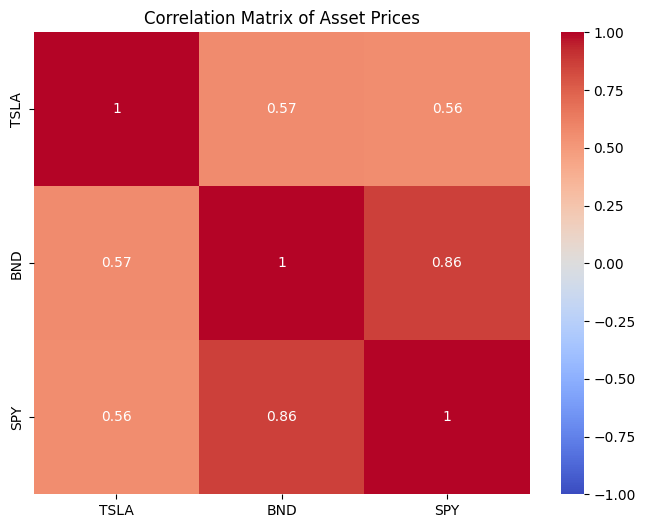

In [13]:
# 1. Correlation Analysis
# Calculate the correlation matrix of the normalized asset prices
correlation_matrix = data[['TSLA', 'BND', 'SPY']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Plot a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Asset Prices")
plt.show()

In [14]:
# 2. Stationarity Testing with Augmented Dickey-Fuller (ADF) Test
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for Tesla
adf_test = adfuller(data['TSLA'].dropna())
print("Augmented Dickey-Fuller Test for Tesla (TSLA)")
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Check if the series is stationary based on p-value
if adf_test[1] < 0.05:
    print("TSLA time series is stationary.")
else:
    print("TSLA time series is non-stationary.")


Augmented Dickey-Fuller Test for Tesla (TSLA)
ADF Statistic: -1.474650228763699
p-value: 0.5460121720718151
Critical Values: {'1%': np.float64(-3.4330229961087557), '5%': np.float64(-2.8627209046733073), '10%': np.float64(-2.5673986431191405)}
TSLA time series is non-stationary.


In [15]:
# 3. Additional Risk Metrics
# Calculate Maximum Drawdown
def calculate_max_drawdown(series):
    roll_max = series.cummax()
    daily_drawdown = series / roll_max - 1.0
    max_drawdown = daily_drawdown.cummin()
    return max_drawdown.min()

max_drawdown = calculate_max_drawdown(data['TSLA'])
print(f"Maximum Drawdown for Tesla (TSLA): {max_drawdown:.2f}")

# Calculate Sortino Ratio (penalizing downside risk only)
downside_std = data['TSLA_pct_change'][data['TSLA_pct_change'] < 0].std()
sortino_ratio = (mean_return - risk_free_rate) / downside_std
print(f"Sortino Ratio for Tesla: {sortino_ratio:.2f}")


Maximum Drawdown for Tesla (TSLA): -1.00
Sortino Ratio for Tesla: inf


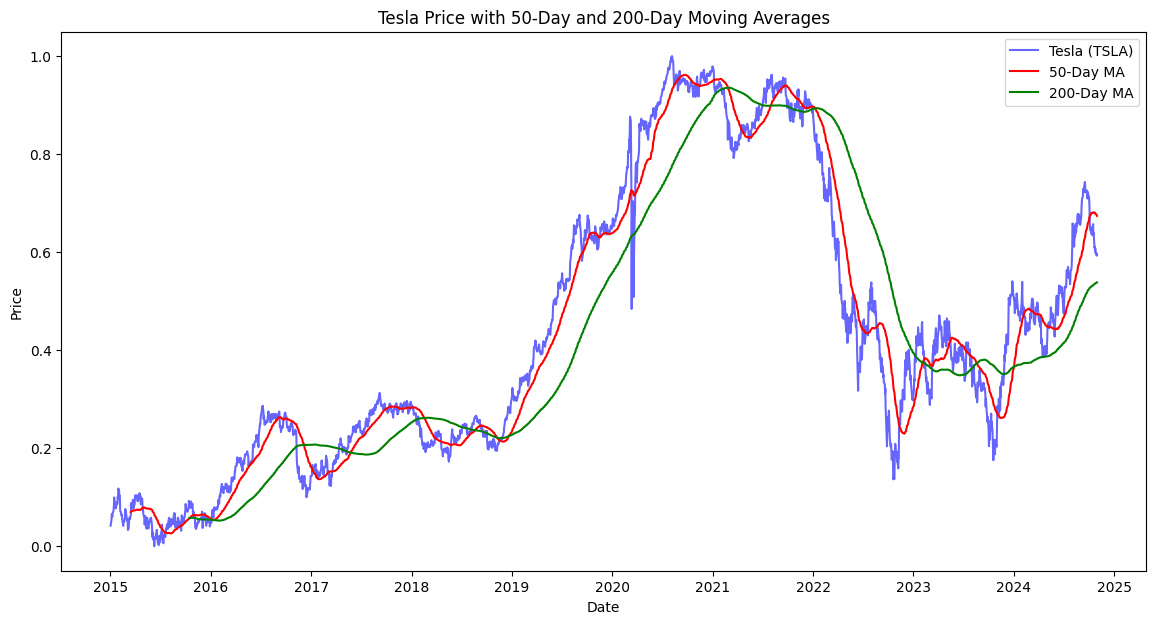

In [16]:
# 4. Moving Average Crossover (50-day vs 200-day) for Buy/Sell Signals
data['TSLA_50_MA'] = data['TSLA'].rolling(window=50).mean()
data['TSLA_200_MA'] = data['TSLA'].rolling(window=200).mean()

# Plot moving averages with Tesla price
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['TSLA'], label='Tesla (TSLA)', color='blue', alpha=0.6)
plt.plot(data['Date'], data['TSLA_50_MA'], label='50-Day MA', color='red')
plt.plot(data['Date'], data['TSLA_200_MA'], label='200-Day MA', color='green')
plt.title('Tesla Price with 50-Day and 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_5016\1070638934.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][50:] = np.where(data['TSLA_50_MA'][50:] > data['TSLA_200_MA'][50:], 1, 0)
C:\Users\hp\AppData\Local\Temp\ipykernel_50

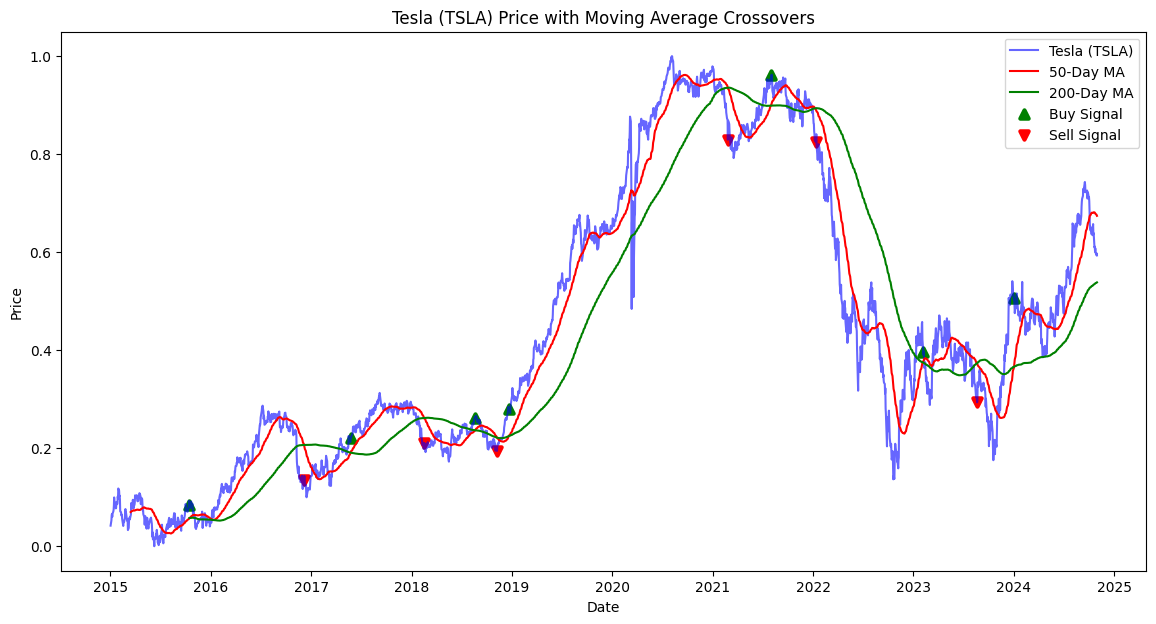

In [17]:
# Identify crossover points
data['Signal'] = 0
data['Signal'][50:] = np.where(data['TSLA_50_MA'][50:] > data['TSLA_200_MA'][50:], 1, 0)
data['Crossover'] = data['Signal'].diff()

# Plot crossovers on the price chart
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['TSLA'], label='Tesla (TSLA)', color='blue', alpha=0.6)
plt.plot(data['Date'], data['TSLA_50_MA'], label='50-Day MA', color='red')
plt.plot(data['Date'], data['TSLA_200_MA'], label='200-Day MA', color='green')

# Mark buy signals
buy_signals = data[data['Crossover'] == 1]
sell_signals = data[data['Crossover'] == -1]

plt.scatter(buy_signals['Date'], buy_signals['TSLA'], label='Buy Signal', marker='^', color='green', lw=3)
plt.scatter(sell_signals['Date'], sell_signals['TSLA'], label='Sell Signal', marker='v', color='red', lw=3)
plt.title('Tesla (TSLA) Price with Moving Average Crossovers')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
